c:\Users\wanxi.wu\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32428 (\N{CJK UNIFIED IDEOGRAPH-7EAC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\wanxi.wu\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\wanxi.wu\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\wanxi.wu\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\wanxi.wu\AppData\Local\

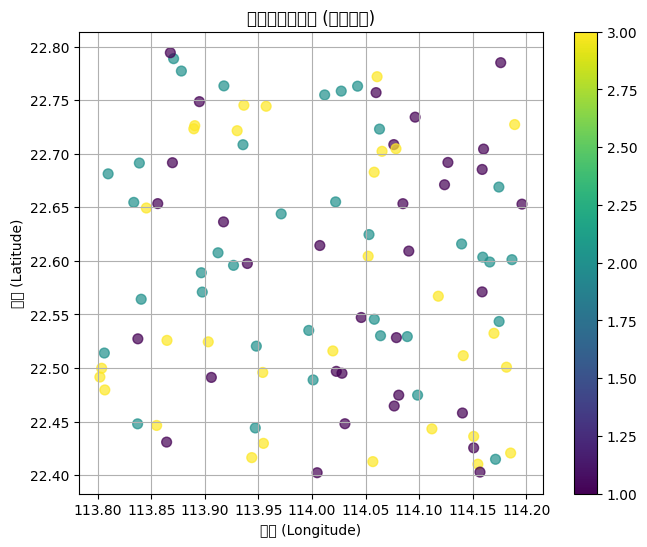

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# 生成模拟经纬度数据（假设有3个聚类）
np.random.seed(42)
num_points = 100
clusters = np.random.choice([1, 2, 3], num_points)  # 随机分配 3 个类别
lats = np.random.uniform(22.4, 22.8, num_points)  # 深圳地区纬度
lons = np.random.uniform(113.8, 114.2, num_points)  # 深圳地区经度

# 创建 DataFrame
df = pd.DataFrame({'Longitude': lons, 'Latitude': lats, 'Cluster_ID': clusters})

# 转换为 GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df.Longitude, df.Latitude)])

# 绘制地图
fig, ax = plt.subplots(figsize=(8, 6))
gdf.plot(ax=ax, column='Cluster_ID', cmap='viridis', legend=True, markersize=50, alpha=0.7)
plt.title("聚类分布可视化 (模拟数据)")
plt.xlabel("经度 (Longitude)")
plt.ylabel("纬度 (Latitude)")
plt.grid(True)
plt.show()